In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

plt.rc('font', family='sans-serif')
plt.rc('font', serif='Arial')
plt.rc('text', usetex='false')

try:
    plt.style.use('../custom.mplstyle')
except IOError:
    plt.rc('font', size=10)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=12, titlesize=12)
    plt.rc('legend', fontsize=8)

/home/mgalactus/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mgalactus/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from Bio import Phylo

In [3]:
from nadist.pure.spatial import euclidean_pdist
from scipy.spatial.distance import pdist, squareform

In [4]:
from sklearn import linear_model

In [5]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [6]:
def expected(values, pseudo):
    return sum(np.log(1 - values + pseudo))/values.shape[0]

In [7]:
evol = {x.rstrip()
        for x in open('../input/evolution_experiment.txt')}

In [8]:
t = Phylo.read('../input/tree.nwk', 'newick')

In [9]:
ref = None
for x in t.get_terminals():
    x.name = x.name.split('_')[0]
    if 'genome' in x.name:
        x.name = 'NT12001'
        ref = x

In [10]:
strains = {x.name for x in t.get_terminals()}

In [11]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0],
            inplace=True)
f = pd.read_table('../input/chemical/emap.fdr.txt')
f.set_index(f.columns[0],
            inplace=True)
a = a.loc[strains]
f = f.loc[strains]
v = a[a < 0][f < 0.05]
v[np.invert(np.isnan(v))] = 1
v[np.isnan(v)] = 0
v[np.isnan(a)] = np.nan

In [12]:
p = squareform(euclidean_pdist(a.values))
p = pd.DataFrame(p,
                 index=a.index,
                 columns=a.index)

In [13]:
acorr = a.T.corr()

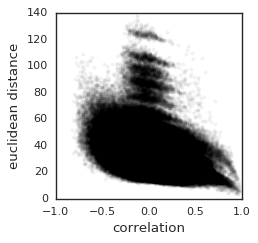

In [14]:
plt.figure(figsize=(3, 3))

plt.plot(acorr.values[np.triu_indices_from(acorr.values, k=1)].flatten(),
         p.values[np.triu_indices_from(acorr.values, k=1)].flatten(),
         'k.',
         alpha=0.05)

plt.xlabel('correlation')
plt.ylabel('euclidean distance');

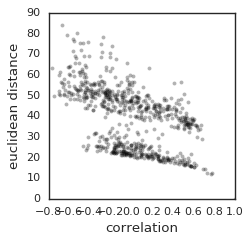

In [15]:
plt.figure(figsize=(3, 3))

plt.plot(acorr.loc['NT12001'],
         p.loc['NT12001'],
         'k.',
         alpha=0.3)

plt.xlabel('correlation')
plt.ylabel('euclidean distance');

In [16]:
res = []
for s in strains:
    if s == 'NT12001':
        continue
    res.append((s, t.distance(ref.name, s), p.loc['NT12001', s]))
r1 = pd.DataFrame(res)
r1.columns = ['strain', 'phylo', 'pheno']
r1.set_index('strain', inplace=True)
r1.dropna(inplace=True)

In [17]:
res = []
for s1, s2 in itertools.combinations(strains, 2):
    if s1 in evol or s2 in evol:
        kind = 'evol'
    else:
        kind = 'natural'
    res.append((s1, s2, t.distance(s1, s2), p.loc[s1, s2],
                kind))
r = pd.DataFrame(res)
r.columns = ['strain1', 'strain2', 'phylo', 'pheno', 'kind']
r.dropna(inplace=True)

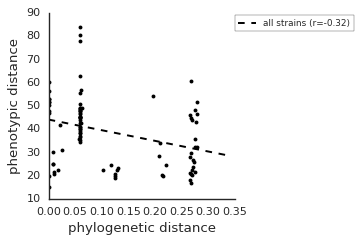

In [18]:
plt.figure(figsize=(3, 3))

plt.plot(r[r.strain1 == 'NT12001'].phylo,
         r[r.strain1 == 'NT12001'].pheno,
         'k.',
         alpha=1,
         label='_')

l = stats.linregress(r[r.strain1 == 'NT12001'].phylo,
                     r[r.strain1 == 'NT12001'].pheno)
fn = l.intercept + l.slope * np.linspace(0, r.phylo.max())
plt.plot(np.linspace(0, r.phylo.max()),
         fn,
         'k--',
         label='all strains (r=%.2f)' % l.rvalue)

plt.legend(loc=(1, 0.9),
           frameon=True)

plt.xlabel('phylogenetic distance')
plt.ylabel('phenotypic distance')

sns.despine();

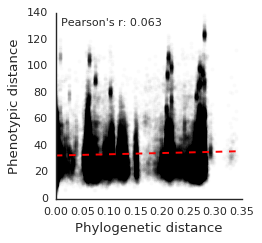

In [19]:
plt.figure(figsize=(3, 3))

tmp = plt.plot(r.phylo,
         r.pheno,
         'k.',
         alpha=0.02,
         label='_')
for t in tmp:
    t.set_rasterized(True)
# plt.plot(r[r.kind == 'natural'].phylo,
#          r[r.kind == 'natural'].pheno,
#          'k.',
#          alpha=0.05,
#          label='_')
# plt.plot(r[r.kind == 'evol'].phylo,
#          r[r.kind == 'evol'].pheno,
#          'r.',
#          alpha=0.01,
#          label='_')

l = stats.linregress(r.phylo,
                     r.pheno)
fn = l.intercept + l.slope * np.linspace(0, r.phylo.max())
plt.plot(np.linspace(0, r.phylo.max()),
         fn,
         'r--')

plt.text(0.01, 130,
         'Pearson\'s r: %.3f' % (l.rvalue))

# l = stats.linregress(r[r.kind == 'natural'].phylo,
#                      r[r.kind == 'natural'].pheno)
# fn = l.intercept + l.slope * np.linspace(0, r[r.kind == 'natural'].phylo.max())
# plt.plot(np.linspace(0, r[r.kind == 'natural'].phylo.max()),
#          fn,
#          'k-',
#          label='Natural isolates (r=%.2f)' % l.rvalue)

# plt.legend(loc=(1, 0.9),
#            frameon=True)

plt.xlabel('Phylogenetic distance')
plt.ylabel('Phenotypic distance')

sns.despine()
plt.savefig('sfig3a.svg', dpi=96);

In [20]:
import numpy as np
import pandas as pd
from scipy import stats
from ete3 import Tree

In [21]:
def get_tree(infile):
    tree = Tree(infile)

    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.replace("'", '').split('.')[0]
        if x.name == 'genome':
            x.name = 'NT12001_189'
    strains = {x.name.split('_')[0]
               for x in tree.traverse()
               if x.is_leaf()}
    for s in strains:
        nodes = sorted([x
                        for x in tree.traverse()
                        if x.name.startswith(s)],
                       key=lambda x: x.name)
        if len(nodes) == 1:
            continue
        for node in nodes[1:]:
            node.delete()
    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.split('_')[0]
    tree.set_outgroup(tree.get_midpoint_outgroup())

    return tree

In [22]:
tree = get_tree('../input/tree.nwk')

In [23]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0], inplace=True)
f = pd.read_table('../input/chemical/emap.fdr.txt')
f.set_index(f.columns[0], inplace=True)
v = a[f < 0.05]
v = v[v < 0]
v[np.invert(np.isnan(v))] = 1
v[np.isnan(v)] = 0
v[np.isnan(a)] = np.nan

In [24]:
p = {x: v.loc[x].dropna().sum() / v.loc[x].dropna().shape[0]
    for x in v.index}

In [25]:
for x in tree.traverse():
    if not x.is_leaf():
        continue
    if x.name == 'NT12001':
        break
res = []
for y in tree.traverse():
    if not y.is_leaf():
        continue
    res.append((y.name,
                tree.get_distance(x, y),
                p.get(y.name)))
r = pd.DataFrame(res)
r.columns = ['strain', 'dist', 'sick']
r = r.dropna()

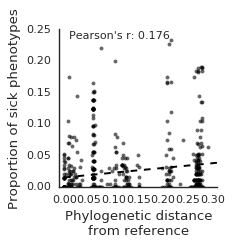

In [26]:
plt.figure(figsize=(3, 3))

l = stats.linregress(r['dist'],
                     r['sick'])
plt.plot(r['dist'],
         r['sick'],
         'k.',
         alpha=0.6,
         label='_')

fn = l.intercept + l.slope * np.linspace(0, 0.31)
plt.plot(np.linspace(0, 0.31),
         fn,
         'k--')

plt.ylabel('Proportion of sick phenotypes')
plt.xlabel('Phylogenetic distance\nfrom reference')

plt.xlim(-0.01, 0.31)

plt.text(0.01,
         0.235,
         'Pearson\'s r: %.3f' % l.rvalue)

sns.despine()
plt.tight_layout()
plt.savefig('sfig3b.svg', dpi=150)

In [27]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.colors as colors
from statsmodels.sandbox.stats.multicomp import multipletests
from ete3 import TreeStyle, NodeStyle, Tree, RectFace

In [28]:
def get_tree(infile):
    tree = Tree(infile)

    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.replace("'", '').split('.')[0]
        if x.name == 'genome':
            x.name = 'NT12001_189'
    strains = {x.name.split('_')[0]
               for x in tree.traverse()
               if x.is_leaf()}
    for s in strains:
        nodes = sorted([x
                        for x in tree.traverse()
                        if x.name.startswith(s)],
                       key=lambda x: x.name)
        if len(nodes) == 1:
            continue
        for node in nodes[1:]:
            node.delete()
    for x in tree.traverse():
        if not x.is_leaf():
            continue
        x.name = x.name.split('_')[0]
    tree.set_outgroup(tree.get_midpoint_outgroup())

    return tree

In [29]:
def draw_tree(pstrains, names=False, subset=None):
    evol = {x.rstrip()
            for x in open('../input/evolution_experiment.txt')}
    
    tree = get_tree('../input/tree.nwk')

    strains = {x.name for x in tree.traverse()
               if x.name != ''}
    if subset is None:
        subset = strains
    evol_tree = {x.name
                 for x in tree.traverse()
                 if x.name in evol}

    commensals = {}
    for x in strains:
        if pstrains[x] == 'Commensal strain':
            commensals[x] = colors.cnames['blue']
        elif pstrains[x] == 'Pathogenic strain':
            commensals[x] = colors.cnames['red']
        else:
            commensals[x] = colors.cnames['white']

    ref = NodeStyle()
    ref['fgcolor'] = sns.xkcd_rgb['light red']
    inner = NodeStyle()
    inner['size'] = 0
    for n in tree.traverse():
        if not n.is_leaf():
            n.set_style(inner)
            continue
        if n.name not in subset:
            continue
        if not names:
            r = RectFace(10, 3,
                         commensals[n.name],
                         commensals[n.name])
            n.add_face(r, 0,
                       position="aligned")
        ev = NodeStyle()
        ev["fgcolor"] = "black"
        ev['size'] = 3
        n.set_style(ev)

    circular_style = TreeStyle()
    circular_style.mode = "c"
    if not names:
        circular_style.scale = 1350
    else:
        circular_style.scale = 7300
    circular_style.show_leaf_name = names
    return tree, circular_style

In [30]:
strains = pd.read_table('../input/strains.tsv')
strains.set_index('Strain Identifier', inplace=True)

In [31]:
sdict = strains['Phenotype'].to_dict()

In [32]:
tree, circular_style = draw_tree(sdict,
                                 False)
tree.render('sfig3c.svg',
            h=7.5,
            units="in",
            tree_style=circular_style,
            dpi=90,
            );

In [33]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0], inplace=True)
f = pd.read_table('../input/chemical/emap.fdr.txt')
f.set_index(f.columns[0], inplace=True)
z = a[a < 0][f < 0.05]
z[np.invert(np.isnan(z))] = 1
z[np.isnan(z)] = 0
z[np.isnan(a)] = np.nan
fake = a[f > 10]
fake[np.isnan(fake)] = 1
fake[np.isnan(a)] = np.nan

In [34]:
data = [z.loc[strains[strains.Phenotype == 'Commensal strain'].index].T.sum()
        /
        fake.loc[strains[strains.Phenotype == 'Commensal strain'].index].T.sum(),
        z.loc[strains[strains.Phenotype == 'Pathogenic strain'].index].T.sum()
        /
        fake.loc[strains[strains.Phenotype == 'Pathogenic strain'].index].T.sum()]

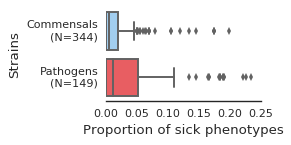

In [35]:
plt.figure(figsize=(2.5, 1.5))

sns.boxplot(data=data,
            orient='h',
            palette=[sns.xkcd_rgb['light blue'],
                     sns.xkcd_rgb['light red']])
plt.text

plt.xlabel('Proportion of sick phenotypes')
plt.yticks([0, 1],
           ['Commensals\n(N=%d)' % data[0].dropna().shape[0],
            'Pathogens\n(N=%d)' % data[1].dropna().shape[0]])
plt.ylabel('Strains')
plt.xlim(0, 0.25)
sns.despine(left=True)
plt.savefig('sfig3d.svg',
            dpi=90)

In [36]:
cohen_d(data[0].dropna(),
        data[1].dropna())

-0.65052191877348653

In [37]:
stats.ttest_ind(data[0].dropna(),
                data[1].dropna())

Ttest_indResult(statistic=-6.6330127205670406, pvalue=8.7014490123127009e-11)

In [38]:
import numpy as np
import random
import pandas as pd
from scipy import stats

In [39]:
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [40]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0], inplace=True)
d = pd.read_table('../input/chemical/all_genes_matched_and_joined_New_NT.txt')
d.set_index(d.columns[0], inplace=True)
c = {x.rstrip().split()[1]: x.split()[0]
     for x in open('../input/chemical/shared_conditions.txt')}
d = d.drop('A22.0.5..', axis=1)
d = d.drop('TETRACYCLINE.0.5...UNSPECIFIED', axis=1)
d.columns = [c.get(x, x)
             for x in d.columns]
conds = set(a.columns).intersection(d.columns)
a = a[list(conds)]
d = d[list(conds)]

In [41]:
r = []
for i in range(a.shape[1]+1):
    r.append([i, a.dropna(thresh=i).shape[0]])

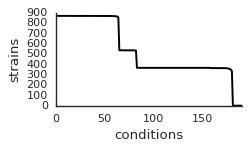

In [42]:
plt.figure(figsize=(3, 1.5))

plt.plot(np.array(r)[:, 0],
         np.array(r)[:, 1],
         'k-')

plt.xlim(0, a.shape[1])
plt.xlabel('conditions')
plt.ylabel('strains')

sns.despine();

In [43]:
a = a.dropna(thresh=155)

In [44]:
v = Imputer(axis=1).fit_transform(a)
v = pd.DataFrame(v,
                 index=a.index,
                 columns=a.columns)

In [45]:
f = Imputer(axis=1).fit_transform(d)
f = pd.DataFrame(f,
                 index=d.index,
                 columns=d.columns)

In [46]:
t = np.concatenate((f, v))

In [47]:
p = PCA()
c = p.fit_transform(t)

In [48]:
plt.rc('font', size=10)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=8)

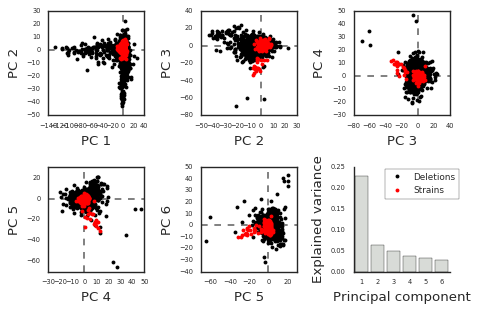

In [49]:
plt.figure(figsize=(6, 4))

ax = plt.subplot(236)
sns.barplot(data=[[x] for x in p.explained_variance_ratio_[:6]],
            color=sns.xkcd_rgb['light grey'])

plt.xticks(range(6),
           ['%d' % (x + 1)
            for x in range(6)])
plt.xlabel('Principal component')
plt.ylabel('Explained variance')

sns.despine(ax=ax)

for i in range(5):
    plt.subplot(2, 3, i+1)
    
    tmp = plt.plot(c[:f.shape[0], i],
             c[:f.shape[0], i+1],
             'k.',
             label='Deletions')
    for t in tmp:
        t.set_rasterized(True)

    tmp = plt.plot(c[f.shape[0]:, i],
             c[f.shape[0]:, i+1],
             'r.',
             label='Strains')
    for t in tmp:
        t.set_rasterized(True)

    plt.xlabel('PC %d' % (i + 1))
    plt.ylabel('PC %d' % (i + 2))

    plt.axvline(0,
                color='grey',
                ls='dashed',
                zorder=0)
    plt.axhline(0,
                color='grey',
                ls='dashed',
                zorder=0)
    
    if i == 4:
        plt.legend(loc=(1.91, 0.7),
                   frameon=True)
        
plt.tight_layout()
plt.savefig('sfig3e.svg',
            dpi=150);

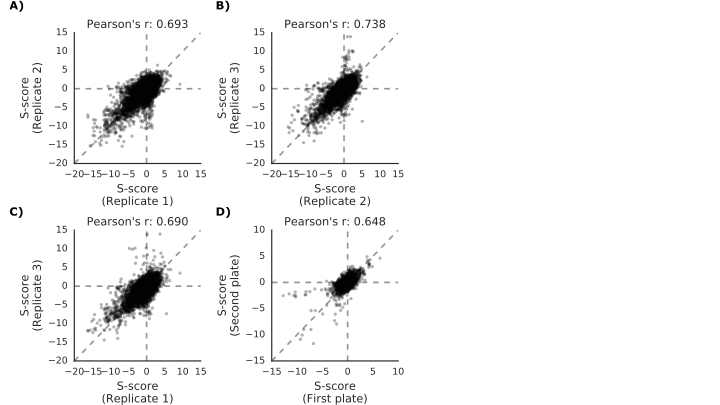

In [2]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("8in", "4.5in")

# load matpotlib-generated figures
fig1 = sg.fromfile('../plots/p_replicates_all.svg')
# fig2 = sg.fromfile('sfig3a.svg')
# fig3 = sg.fromfile('sfig3b.svg')
# fig4 = sg.fromfile('sfig3e.svg')
# fig5 = sg.fromfile('sfig3c.svg')
# fig6 = sg.fromfile('sfig3d.svg')

# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(10, 10, scale=1)
# plot2 = fig2.getroot()
# plot2.moveto(470, -5, scale=1)
# plot3 = fig3.getroot()
# plot3.moveto(450, 220, scale=1)
# plot4 = fig4.getroot()
# plot4.moveto(10, 450, scale=1)
# plot5 = fig5.getroot()
# plot5.moveto(450, 250, scale=0.71)
# plot6 = fig6.getroot()
# plot6.moveto(645, 340, scale=1)

# add text labels
txt1 = sg.TextElement(10,  10, "A)", size=12, weight="bold")
txt2 = sg.TextElement(230, 10, "B)", size=12, weight="bold")
txt3 = sg.TextElement(10, 230, "C)", size=12, weight="bold")
txt4 = sg.TextElement(230, 230, "D)", size=12, weight="bold")
# txt5 = sg.TextElement(440, 15, "E)", size=12, weight="bold")
# txt6 = sg.TextElement(440, 220, "F)", size=12, weight="bold")
# txt7 = sg.TextElement(10, 455, "G)", size=12, weight="bold")
# txt8 = sg.TextElement(155, 455, "H)", size=12, weight="bold")
# txt9 = sg.TextElement(295, 455, "I)", size=12, weight="bold")
# txt10 = sg.TextElement(10, 595, "J)", size=12, weight="bold")
# txt11 = sg.TextElement(155, 595, "K)", size=12, weight="bold")
# txt12 = sg.TextElement(295, 595, "L)", size=12, weight="bold")
# txt13 = sg.TextElement(450, 260, "M)", size=12, weight="bold")
# txt14 = sg.TextElement(600, 345, "N)", size=12, weight="bold")


# append plots and labels to figure
fig.append([
            plot1,
#             plot2,
#             plot3,
            ])
fig.append([
            txt1,
            txt2,
            txt3,
            txt4,
#             txt5,
#             txt6,
            ])

# save generated SVG files
# fig.save("../figures/supplementary/sfig3.svg")
fig.save("../figures/supplementary/sfig3.svg")

!convert ../figures/supplementary/sfig3.svg sfig3.png

from IPython.display import Image
Image(filename='sfig3.png')